# Autoencoders in SciKeras

Autencoders are an approach to use nearual networks to distill data into it's most important features, thereby compressing the data. We will be following the [Keras tutorial](https://blog.keras.io/building-autoencoders-in-keras.html) on the topic, which goes much more in depth and breadth than we will here. You are highly encouraged to check out that tutorial if you want to learn about autoencoders in the general sense.



<table align="left"><td>
<a target="_blank" href="https://colab.research.google.com/github/adriangb/scikeras/blob/master/notebooks/Basic_Usage.ipyn">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>  
</td><td>
<a target="_blank" href="https://github.com/adriangb/scikeras/blob/master/notebooks/Basic_Usage.ipynb"><img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a></td></table>

### Table of contents

* [Data](#Data)
* [Define Model](#Define-Keras-Model)
* [Training](#Training)
* [Explore Results](#Explore-Results)

Install SciKeras

In [ ]:
!python -m pip install git+https://github.com/adriangb/scikeras.git@master

Silence TensorFlow warnings to keep output succint.

In [1]:
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')

In [2]:
from tensorflow import keras

## Data

We load the dataset from the Keras tutorial. The dataset consists of images of cats and dogs.

In [3]:
from tensorflow.keras.datasets import mnist
import numpy as np


(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


## Define Keras Model

We will be defining a very simple autencoder.

In [4]:
from tensorflow import keras
from tensorflow.keras import layers


# This is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# This is our input image
input_img = keras.Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = layers.Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = layers.Dense(784, activation='sigmoid')(encoded)

# This model maps an input to its reconstruction
autoencoder_model = keras.Model(input_img, decoded)

# This model maps an input to its encoded representation
encoder_model = keras.Model(input_img, encoded)

# This is our encoded (32-dimensional) input
encoded_input = keras.Input(shape=(encoding_dim,))
# Retrieve the last layer of the autoencoder model
decoder_layer = autoencoder_model.layers[-1]
# Create the decoder model
decoder_model = keras.Model(encoded_input, decoder_layer(encoded_input))

We create a small class that will allow us to call `fit_transform` instead of having to call `fit` and `transform` sequentially.

In [5]:
from sklearn.base import TransformerMixin
from scikeras.wrappers import BaseWrapper


class AutoEncoderTransformer(BaseWrapper, TransformerMixin):
    """Enables the ``transform`` and ``fit_transform`` methods.
    """

    def transform(self, X):
        if not self.initialized():
            self.initialize(X)
        return self.predict(X)

Next, we wrap the Keras Model with Scikeras. Note that we use BaseWrapper instead of KerasClassifier or KerasRegressor since this is not a classificaiton or regression task.

In [6]:
compile_params = {"optimizer": "adam", "loss": "binary_crossentropy"}
fit_params = {"epochs": 50, "batch_size": 256, "shuffle": True}

autoencoder = BaseWrapper(model=autoencoder_model, **compile_params, **fit_params)
encoder = AutoEncoderTransformer(model=encoder_model, **compile_params, **fit_params, verbose=0)
decoder = AutoEncoderTransformer(model=decoder_model, **compile_params, **fit_params, verbose=0)

## Training

To train the model, we pass the input images as both the features and the target. This will train the layers to compress the data as accurately as possible between the encoder and decoder.

In [7]:
autoencoder.fit(x_train, x_train)

Epoch 1/50
235/235 [==============================] - 1s 3ms/step - loss: 0.3779
Epoch 2/50
235/235 [==============================] - 1s 3ms/step - loss: 0.1821
Epoch 3/50
235/235 [==============================] - 1s 3ms/step - loss: 0.1505
Epoch 4/50
235/235 [==============================] - 1s 3ms/step - loss: 0.1318
Epoch 5/50
235/235 [==============================] - 1s 3ms/step - loss: 0.1201
Epoch 6/50
235/235 [==============================] - 1s 3ms/step - loss: 0.1126
Epoch 7/50
235/235 [==============================] - 1s 3ms/step - loss: 0.1073
Epoch 8/50
235/235 [==============================] - 1s 3ms/step - loss: 0.1033
Epoch 9/50
235/235 [==============================] - 1s 3ms/step - loss: 0.1002
Epoch 10/50
235/235 [==============================] - 1s 3ms/step - loss: 0.0980
Epoch 11/50
235/235 [==============================] - 1s 3ms/step - loss: 0.0964
Epoch 12/50
235/235 [==============================] - 1s 3ms/step - loss: 0.0955
Epoch 13/50
235/235 [====

BaseWrapper(
	model=<tensorflow.python.keras.engine.functional.Functional object at 0x149b9a850>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=adam
	loss=binary_crossentropy
	metrics=None
	batch_size=256
	verbose=1
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=50
)

Next we fit the encoder and decoder using training data and then round-trip through both using test data.

In [8]:
roundtrip_imgs = decoder.transform(encoder.transform(x_test))

## Explore Results

Now let's compare our inputs to lossy decoded outputs:

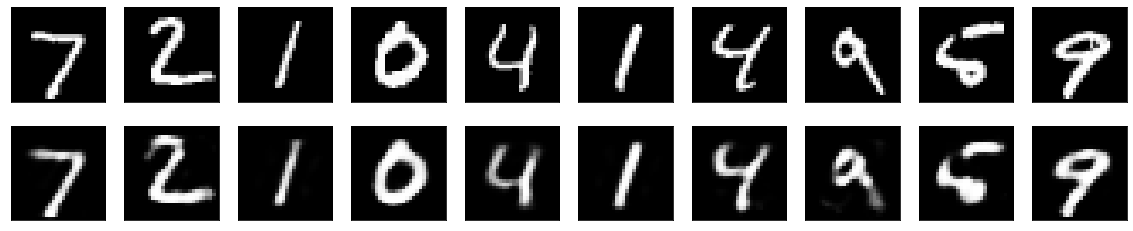

In [9]:
import matplotlib.pyplot as plt


n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(roundtrip_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

What about the compression? Let's check the sizes of the arrays.

In [10]:
encoded_imgs = encoder.transform(x_test)
print(f"x_test.shape[1]: {x_test.shape[1]}")
print(f"encoded_imgs.shape[1]: {encoded_imgs.shape[1]}")
space_saving = (1-encoded_imgs.astype(x_test.dtype).nbytes/x_test.nbytes)*100
print(f"Space saving: {space_saving:0.2f}%")

x_test.shape[1]: 784
encoded_imgs.shape[1]: 32
Space saving: 95.92%
